# Image adjustment

This tutorial will show, step by show, how to apply image alignment on a time series.  
To simplify the tutorial, the time series is actually made of two pictures. Images are provided by the Martinican Landscape Photographic Observatory (_Observatoire Photographique des Paysages de la Martinique_).

We are going to use [OpenCV](https://pypi.org/project/opencv-python/) librairy, a must for image analysis, all along the tutorial.

In [1]:
import cv2

## Load the images
The images are going to be loaded to be processed.

First, we want to set them to the same size. We choose to resize all of them as the smallest image : we need to find out what are the minimum height and width of the series. The images will be resized once loaded.

In [2]:
# Set image path to the images and get images list
import os

path_images = './images/'
images_list = os.listdir(path_images)

print(images_list)

['FT_IMAGE_314.jpg', 'FT_IMAGE_1177.jpg']


In [3]:
# Define the function to return minimum width and heigh of the time series
def get_min_h_w(path_images, images_list):
    h_list, w_list = [], []
    
    for image_name in images_list:
        image = cv2.imread(os.path.join(path_images, image_name), 3)
        h_list.append(image.shape[0])
        w_list.append(image.shape[1])
        
    h = min(h_list)
    w = min(w_list)
    
    return h, w


# Apply the above function to get minimum width and heigh
h, w = get_min_h_w(path_images, images_list)

And finally load the images. In following code lines, `im_ref` and `im` are defining our images. `im_ref` is the reference image while `im` is the one we want to processed.

In [4]:
# Define the loading function
def get_image(image_path, h, w):
    # Load the image
    im = cv2.imread(image_path, 3)
    # Convert to RGB color space (OpenCV is by default in BGR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # and resize it
    im = cv2.resize(im, (w, h))
    
    return im


# Load the two images
im_ref = get_image(os.path.join(path_images, images_list[0]), h, w)
im = get_image(os.path.join(path_images, images_list[1]), h, w)

## Detect keypoints
Keypoints are defined by structures in an image that are distinguishable from their surroundings. Changes in gradient or in intensity within the image are usually used for features identification. For pictures of the same object, the extracted features
should be similar, regardless of the camera position and orientation. It allows to then compute feature points pairs between images to figure out what the transformation between two pictures is.  
One of the most robust and famous algorithms for keypoints extraction is [SIFT](https://robo.fish/wiki/images/5/58/Image_Features_From_Scale_Invariant_Keypoints_Lowe_2004.pdf). It the one we are going to apply now.

In [5]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# Find keypoints and compute descriptors with SIFT
kp_ref, des_ref = sift.detectAndCompute(im_ref, None)
kp, des = sift.detectAndCompute(im, None)

Variables `kpX` and `desX` correspond to keypoints on the image X and their associated descriptor.

## Match keypoints

Now that keypoints sets have been extracted on both images, we would like to match keypoints between the two sets. Matching the keypoints will allow us to determine what is the underlying transformation between the two images.

We are going to use Brute-Force Matcher algorithm to compute keypoints matches and then apply Lowe's ratio test to keep the most reliable matches.  
This step could be time-consuming, depending on the number of keypoints that have to be matched.

In [6]:
import numpy as np

# Create BFMatcher object with default parameters
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.knnMatch(des, des_ref, k=2)

# Store all the good matches as per Lowe's ratio test
# Can play with variable factor:
# if factor = 1, all matches are taken into account,  if factor = 0 none of them are considered
good_matches = []
factor = 0.6
for m, n in matches:
    if m.distance < factor * n.distance:
        good_matches.append(m)
        
# Retrieve your keypoints in `good_matches`
good_kp = np.array([kp[mat.queryIdx].pt for mat in good_matches])
good_kp_ref = np.array([kp_ref[mat.trainIdx].pt for mat in good_matches])

## Adjust image
The established pairwises keypoints at previous steps help us to compute the transformation matrix that has to be apply to adjust the target image, given the reference image.  
We then apply the adjustment.

In [7]:
# Find transformation
m, mask = cv2.findHomography(good_kp, good_kp_ref, cv2.RANSAC, 5.0)

# Apply transformation
im_adjusted = cv2.warpPerspective(im, m, (w, h))

## Visualize the adjustment

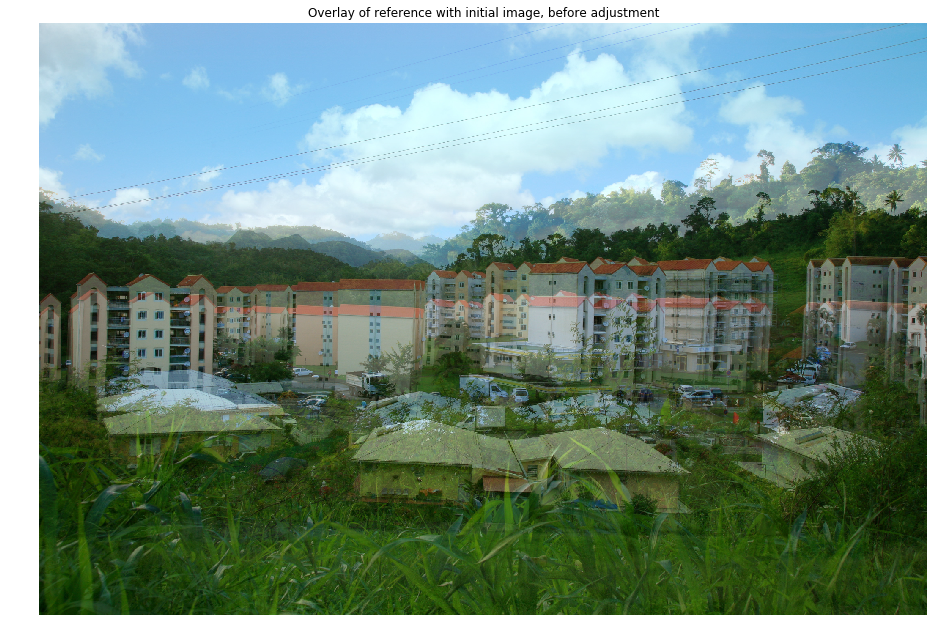

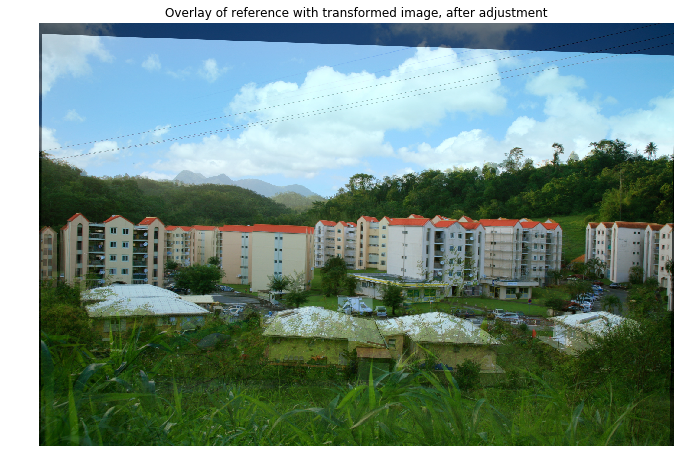

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt

# Plot initial image with reference image
fig, ax = plt.subplots(figsize=(30, 24))
plt.subplot(1, 2, 1)
plt.axis('off')
im_overlay_before = im_ref.copy()
cv2.addWeighted(im_ref, 0.5, im, 0.5, 0, im_overlay_before)
plt.imshow(im_overlay_before)
plt.title("Overlay of reference with initial image, before adjustment")

# Plot transformed image with reference image
fig, ax = plt.subplots(figsize=(30, 24))
plt.subplot(1, 2, 2)
plt.axis('off')
im_overlay_after = im_ref.copy()
cv2.addWeighted(im_ref, 0.5, im_adjusted, 0.5, 0, im_overlay_after)
plt.imshow(im_overlay_after)
plt.title("Overlay of reference with transformed image, after adjustment")

plt.show()

In [25]:
from ipywidgets import interact

def overlay_plot(transparency):
    # Create a figure
    fig, ax = plt.subplots(figsize=(20, 16))
    plt.axis('off')
    # Plot overlay
    im_overlay = im_ref.copy()
    cv2.addWeighted(im_ref, 1-transparency, im_adjusted, transparency, 0, im_overlay)
    plt.imshow(im_overlay)
    plt.title("Overlay of reference with transformed image, after adjustment")
    
    plt.show()


interact(overlay_plot, transparency=(0, 1.0, 0.1));

interactive(children=(FloatSlider(value=0.5, description='transparency', max=1.0), Output()), _dom_classes=('w…

In [16]:
from ipywidgets import interact

def overlay_plot(transformed):
    # Create a figure
    fig, ax = plt.subplots(figsize=(20, 16))
    plt.axis('off')
    # Plot overlay
    im_change = im_ref.copy()
    im_overlay = im_ref.copy()
    cv2.addWeighted(im, 1-transformed, im_adjusted, transformed, 0, im_change)
    cv2.addWeighted(im_ref, 0.5, im_change, 0.5, 0, im_overlay)
    plt.imshow(im_overlay)
    plt.title("Overlay of reference with processed image, before adjustement (transformed = 0) and after adjustment (transformed = 1)")
    
    plt.show()


interact(overlay_plot, transformed=(0, 1.0, 0.1));

interactive(children=(FloatSlider(value=0.5, description='transformed', max=1.0), Output()), _dom_classes=('wi…

If satisfied, you could save the transformed image

In [18]:
# Convert the image back to BGR to fit with OpenCV function cv2.imwrite
im_adjusted = cv2.cvtColor(im_adjusted, cv2.COLOR_RGB2BGR)

# Save it
cv2.imwrite(os.path.join(path_images,'adjusted.png'), im_adjusted);